# Imports

In [ ]:
!pip install scikit-optimize

     |████████████████████████████████| 101 kB 4.6 MB/s 


In [ ]:
!pip install pyproj==2.6.1.post1

     |████████████████████████████████| 10.9 MB 6.1 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import itertools
import scipy.optimize as opt
import lightgbm as lgb
import os
import pyproj
import warnings
warnings.filterwarnings("ignore", category=Warning)

from google.colab import drive
from google.colab import files
from tqdm.notebook import tqdm
from pathlib import Path
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.metrics import accuracy_score
from pyproj import Proj, transform
from pyproj import Transformer
from cv2 import Rodrigues

# Connecting to Google Drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# Global Variables

In [ ]:
DATAPATH = Path("/content/drive/MyDrive/google-smartphone-decimeter-challenge")

#DF_BASELINE_TRAIN = pd.read_csv(DATAPATH / "baseline_train_samsung.csv")
#DF_BASELINE_TEST = pd.read_csv('/content/baseline_test_samsung.csv')

DF_SAMPLE = pd.read_csv(DATAPATH / "sample_submission.csv")
BASELINE_TRAIN = pd.read_csv(DATAPATH / "baseline_locations_train.csv")
BASELINE_TEST = pd.read_csv(DATAPATH / "baseline_locations_test.csv")

TRANSFORMER = pyproj.Transformer.from_crs(
    {"proj":'geocent', "ellps":'WGS84', "datum":'WGS84'},
    {"proj":'latlong', "ellps":'WGS84', "datum":'WGS84'},)

CONSTEL_FREQ_TABLE = {
    0: {'UNKNOWN': (0, 999999999999)},
    1: {
        'GPS_L1': (1563000000, 1587000000),
        'GPS_L2': (1215000000, 1240000000),
        'GPS_L5': (1164000000, 1189000000)
    },
    3: {
        'GLO_G1': (1593000000, 1610000000),
        'GLO_G2': (1237000000, 1254000000)
    },
    4: {
        'QZS_J1': (1563000000, 1587000000),
        'QZS_J2': (1215000000, 1240000000),
        'QZS_J5': (1164000000, 1189000000)
    },
    5: {
        'BDS_B1C': (1569000000, 1583000000),
        'BDS_B1I': (1553000000, 1568990000),
        'BDS_B2A': (1164000000, 1189000000),
        'BDS_B2B': (1189000000, 1225000000)
    },
    6: {
        'GAL_E1': (1559000000, 1591000000),
        'GAL_E5A': (1164000000, 1189000000),
        'GAL_E5B': (1189000000, 1218000000),
        'GAL_E6': (1258000000, 1300000000)
    },
    7: {
        'IRN_S': (2472000000, 2512000000),
        'IRN_L5': (1164000000, 1189000000)
    },
}

# LightGBM

params = {
        'metric':'mse',
        'objective':'regression',
        'seed':2021,
        'boosting_type':'gbdt',
        'early_stopping_rounds':10,
        'subsample':0.7,
        'feature_fraction':0.7,
        'bagging_fraction': 0.7,
        'reg_lambda': 10
        }
window_size = 30
verbose_flag = True
folds = 5

# Methods

In [ ]:
def gnss_log_to_dataframes(path: str) -> dict:
    """
    Parses GNSS logs to a dictionary of Pandas dataframes
    """
    
    gnss_section_names = {'Raw','UncalAccel', 'UncalGyro', 'UncalMag', 'Fix', 'Status', 'OrientationDeg'}

    with open(path) as f_open:
        datalines = f_open.readlines()
        datalines = [v for v in datalines if v not in ['OrientationDe\n', 'Unca\n', 'Orientatio\n']]

    datas = {k: [] for k in gnss_section_names}
    gnss_map = {k: [] for k in gnss_section_names}

    for dataline in datalines:
        is_header = dataline.startswith('#')
        dataline = dataline.strip('#').strip().split(',')
        
        if is_header and dataline[0] in gnss_section_names:
            gnss_map[dataline[0]] = dataline[1:]
        elif not is_header:
            datas[dataline[0]].append(dataline[1:])

    results = dict()

    for k, v in datas.items():
        results[k] = pd.DataFrame(v, columns=gnss_map[k])

    for k, df in results.items():
        for col in df.columns:
            if col == 'CodeType':
                continue
            results[k][col] = pd.to_numeric(results[k][col])

    return results

In [ ]:
def signal_type_from_constellation_and_frequency(constel: int, freq_hz: float) -> object:
    """
    Returns the signal type for the given constellation and frequency.
    """
    
    freqs = CONSTEL_FREQ_TABLE.get(constel, {})

    for id_freq_range in freqs.items():
      rng = id_freq_range[1]
      if rng[0] <= freq_hz <= rng[1]:
        return id_freq_range[0]

    return list(CONSTEL_FREQ_TABLE.get(0, {}))[0]

In [ ]:
def ellipsoid_to_ecef(lat: float, lon: float, alt: float) -> list:
    """
    Converts coordinates from ellipsoidal to cartesian in the Earth-Centered,
    Earth-Fixed frame.
    """

    # convert to radians

    rad_lat = lat * (np.pi / 180.0)
    rad_lon = lon * (np.pi / 180.0)
    a    = 6378137.0

    # f is the flattening factor

    finv = 298.257223563
    f = 1 / finv   

    # e is the eccentricity

    e2 = 1 - (1 - f) * (1 - f)    

    # N is the radius of curvature in the prime vertical

    N = a / np.sqrt(1 - e2 * np.sin(rad_lat) * np.sin(rad_lat))
    x = (N + alt) * np.cos(rad_lat) * np.cos(rad_lon)
    y = (N + alt) * np.cos(rad_lat) * np.sin(rad_lon)
    z = (N * (1 - e2) + alt)        * np.sin(rad_lat)
      
    return x, y, z

In [ ]:
def ecef_to_ellipsoid(x: float, y: float, z: float) -> list:
    """
    Converts coordinates from cartesian in the Earth-Centered,
    Earth-Fixed frame to ellipsoidal.
    """

    lon, lat, alt = TRANSFORMER.transform(x,y,z,radians=False)
    return lon, lat, alt

In [ ]:
def rotate_satellite(x: float, y: float, z: float, PrM: float) -> list:
    """
    Rotates the coordinates of the satellites to account for the rotation of 
    Earth during the time of signal transmission.
    """

    c = 299792458
    omega = 7.292115 * 1e-5
    t = PrM/c

    rotation_matrix = np.matrix(np.array([[math.cos(omega*t), math.sin(omega*t), 0],
                                          [-math.sin(omega*t), math.cos(omega*t), 0],
                                          [0, 0, 1]]))
    position_vector = np.matrix.transpose(np.matrix(np.array([x, y, z])))
    
    return np.array(np.matmul(rotation_matrix, position_vector))

In [ ]:
def read_ground_truth(data_path: str) -> pd.DataFrame:
    """
    Reads ground truth data
    """
    ground_truths = (data_path / "train").rglob("ground_truth.csv")
    df_sample_trails_gt = pd.concat([pd.read_csv(filepath) for filepath in tqdm(ground_truths, total=73, desc="Reading ground truth data")], ignore_index=True)
    df_sample_trails_gt = df_sample_trails_gt.sort_values(by=["collectionName", "phoneName", "millisSinceGpsEpoch"], 
                                                          ignore_index=True)
    df_sample_trails_gt['phone'] = df_sample_trails_gt['collectionName'] + "_" + df_sample_trails_gt['phoneName']

    return df_sample_trails_gt

In [ ]:
def preprocess(derived: pd.DataFrame, raw: pd.DataFrame) -> pd.DataFrame:
    """
    Merges derived data with raw data from GNSS logs. Drops unnecessary columns.
    """

    # Extracting the data

    data_raw = raw
    data_derived = derived

    # GNSS Log time system is different from the derived time system 
    # (millisSinceGpsEpoch). In order to match the derived rows to the GNSS Log
    # rows, we calculate millisSinceGpsEpoch variable for every GNSS Log row.

    data_raw['millisSinceGpsEpoch'] = np.floor(
        (data_raw['TimeNanos'] - data_raw['FullBiasNanos']) / 1000000.0).astype(int)

    raw_timestamps = data_raw['millisSinceGpsEpoch'].unique()
    derived_timestamps = data_derived['millisSinceGpsEpoch'].unique()

    indexes = np.searchsorted(raw_timestamps, derived_timestamps)
    
    from_t_to_fix_derived = dict(zip(derived_timestamps, raw_timestamps[indexes-1]))
    data_derived['millisSinceGpsEpoch'] = np.array(
        list(map(lambda v: from_t_to_fix_derived[v], 
                data_derived['millisSinceGpsEpoch'])))
    
    # Calculating the signal type for each GNSS Log row, also to help with matching
    # derived rows to GNSS Log rows.

    signal_types = itertools.chain(*[c.keys() for c in CONSTEL_FREQ_TABLE.values()])
    sig_type_cat = pd.api.types.CategoricalDtype(categories=signal_types)

    data_raw.rename(columns = {"ConstellationType" : "constellationType"}, 
                    inplace=True)
    data_raw['signalType'] = data_raw.apply(
        lambda r: signal_type_from_constellation_and_frequency(
            r.constellationType, r.CarrierFrequencyHz), axis=1)

    # In the GNSS Log, QZSS satellites have Svids ranging from 193 to 200 and in 
    # derived they range from 1 to 4. We change the GNSS Log Svids correspondingly.

    new_to_old = {1:(183, 193), 2:(184, 194, 196), 
                  3:(187, 189, 197, 199), 4:(185, 195, 200)}

    old_to_new={}
    for new_svid, old_svids in new_to_old.items():
      for s in old_svids:
        old_to_new[s] = new_svid

    data_raw.rename(columns = {"Svid" : "svid"}, inplace = True)
    data_raw['svid'] = data_raw.apply(
        lambda r: old_to_new.get(r.svid, r.svid) if r.constellationType == 4 else r.svid, axis=1)  

    data_derived.signalType = data_derived.signalType.astype(str)
    data_raw.signalType = data_raw.signalType.astype(str)

    n = data_derived.shape[0]
    print('Before merge {}'.format(n))

    data_new = pd.merge(data_derived, data_raw, how = 'inner',
                        on = ['millisSinceGpsEpoch',
                              'svid',
                              'signalType',
                              'constellationType'])
    
    n = data_new.shape[0]
    print('After merge {}'.format(n))
    
    # Removing signals with high uncertainty

    data_new.drop(data_new[(data_new['BiasUncertaintyNanos'] >= 1e6) |
                          (data_new['Cn0DbHz'] < 20) |
                          (data_new['ReceivedSvTimeUncertaintyNanos'] > 500) |
                          (data_new['signalType'] == 'UNKNOWN')].index, 
                          inplace = True)

    # Rotating satellite positions to account for Earth's rotation

    data_new['correctedPrM'] = (data_new['rawPrM'] 
                              + data_new['satClkBiasM'] 
                              - data_new['isrbM'] 
                              - data_new['ionoDelayM'] 
                              - data_new['tropoDelayM'])

    data_new['x'] = data_new.apply(lambda row: rotate_satellite(row['xSatPosM'], row['ySatPosM'], row['zSatPosM'], row['correctedPrM'])[0][0], axis=1)
    data_new['y'] = data_new.apply(lambda row: rotate_satellite(row['xSatPosM'], row['ySatPosM'], row['zSatPosM'], row['correctedPrM'])[1][0], axis=1)
    data_new['z'] = data_new.apply(lambda row: rotate_satellite(row['xSatPosM'], row['ySatPosM'], row['zSatPosM'], row['correctedPrM'])[2][0], axis=1)

    data_new['xSatPosM'] = data_new['x']
    data_new['ySatPosM'] = data_new['y']
    data_new['zSatPosM'] = data_new['z']

    data_new.drop(columns = ['x', 'y', 'z'], inplace = True)
    data_new.drop(columns = ['AgcDb', 
                            'SnrInDb', 
                            'CarrierPhaseUncertainty',
                            'CarrierPhase',
                            'CarrierCycles',
                            'AccumulatedDeltaRangeMeters',
                            'AccumulatedDeltaRangeState',
                            'PseudorangeRateUncertaintyMetersPerSecond',
                            'PseudorangeRateMetersPerSecond',
                            'State',
                            'HardwareClockDiscontinuityCount',
                            'DriftUncertaintyNanosPerSecond',
                            'LeapSecond',
                            'zSatVelMps',
                            'ySatVelMps',
                            'xSatVelMps'], inplace = True)

    return data_new

In [ ]:
def calc_pos_fix(sat_pos: np.ndarray, pr: np.ndarray, weights=1, x0=[0, 0, 0, 0]) -> list:
    '''
    Calculates GPS locations with WLS optimizer
    returns:
    0 -> list with positions
    1 -> pseudorange errors
    Ref: https://www.kaggle.com/foreveryoung/least-squares-solution-from-gnss-derived-data
    '''
    
    n = pr.size
    if n < 3:
        return x0, []

    fx_pos = pr_residual(sat_pos, pr, weights=weights)
    opt_pos = opt.least_squares(fx_pos, x0).x
    return opt_pos, fx_pos(opt_pos, weights=1)

In [ ]:
def pr_residual(sat_pos: np.ndarray, pr: np.ndarray, weights=1) -> np.ndarray:
    """
    Ref: https://www.kaggle.com/foreveryoung/least-squares-solution-from-gnss-derived-data
    """
    def fx_pos(x_hat, weights=weights):
      rows = weights * (np.linalg.norm(sat_pos - x_hat[:3], axis=1) + x_hat[3] - pr)
      return rows
    return fx_pos

In [ ]:
def simple_pipeline(df_trails: pd.DataFrame, base_: float, p1_: float, p2_: float, p3_: float) -> pd.DataFrame:
    """ 
    Simple pipeline to estimate the GNSS receiver location by least squares.
    Modified from original code to include GNSS log data in calculating the 
    weights.
    Ref: https://www.kaggle.com/foreveryoung/least-squares-solution-from-gnss-derived-data
    """
    
    # Parameters

    base = base_
    p1 = p1_
    p2 = p2_
    p3 = p3_

    results = []
    x = [0, 0, 0, 0]
    df_epochs = df_trails.groupby(["collectionName", "phoneName", "millisSinceGpsEpoch"])

    for indices, df_epoch in tqdm(df_epochs, desc="Estimate location by LS for epoch"):
      sat_pos = df_epoch[["xSatPosM","ySatPosM","zSatPosM"]].to_numpy()
      pseudoranges = np.squeeze(df_epoch[["correctedPrM"]].to_numpy())
      cn0 = np.squeeze(df_epoch[["Cn0DbHz"]].to_numpy())
      time_sigma = np.squeeze(df_epoch[["ReceivedSvTimeUncertaintyNanos"]].to_numpy())
      delta_sigma = np.squeeze(df_epoch[["AccumulatedDeltaRangeUncertaintyMeters"]].to_numpy())
      cn0_mean = df_epoch['Cn0DbHz'].mean()
      time_sigma_mean = df_epoch['ReceivedSvTimeUncertaintyNanos'].mean() + 25
      delta_sigma_mean = df_epoch['AccumulatedDeltaRangeUncertaintyMeters'].mean()
      multipath = np.squeeze(df_epoch[["MultipathIndicator"]].to_numpy())

      var_0 = base**(p1*(-cn0[0]/cn0_mean) + 
                    p2*(time_sigma[0]/time_sigma_mean) +
                    p3*(delta_sigma[0]/delta_sigma_mean))
      
      if ((cn0_mean == 0) | (time_sigma_mean == 0) | (delta_sigma_mean == 0)):
          continue

      if not np.all(np.isfinite(var_0/base**(p1*(-cn0/cn0_mean) + 
                                            p2*(time_sigma/time_sigma_mean) +
                                            p3*(delta_sigma/delta_sigma_mean)))):
          continue

      x, _ = calc_pos_fix(sat_pos, 
                          pseudoranges, 
                          (1-0.4*multipath)*var_0/base**(p1*(-cn0/cn0_mean) + 
                                                        p2*(time_sigma/time_sigma_mean) +
                                                        p3*(delta_sigma/delta_sigma_mean)), 
                          x)   

      values = np.squeeze(ecef_to_ellipsoid(*x[:3]))
      results.append([*indices, *values])

    df = pd.DataFrame(results,columns=["collectionName", "phoneName", "millisSinceGpsEpoch", "lngDeg", "latDeg", "heightAboveWgs84EllipsoidM"])
    df['phone'] = df['collectionName'] + '_' + df['phoneName']
    return df

In [ ]:
def replace_sjc_data(data_path: str, dataset_name: str, baseline: pd.DataFrame) -> pd.DataFrame:
    """
    Replaces SJC Samsung data with more accurate positions. 
    """
    derived_files_sjc = (data_path / dataset_name).rglob("*_derived.csv")
    gnss_files_sjc = (data_path / dataset_name).rglob("*_GnssLog.txt")

    df_sample_trails_derived_sjc = pd.concat([pd.read_csv(filepath) for filepath in tqdm(derived_files_sjc, total=6, desc="Reading derived data") if 'SJC' in str(filepath) and 'Samsung' in str(filepath)], ignore_index=True)
    df_sample_trails_raw_sjc = pd.concat([gnss_log_to_dataframes(filepath)['Raw'] for filepath in tqdm(gnss_files_sjc, total=6, desc="Reading gnss data") if 'SJC' in str(filepath) and 'Samsung' in str(filepath)], ignore_index=True)
    df_sample_trails_sjc = preprocess(df_sample_trails_derived_sjc, df_sample_trails_raw_sjc)

    df_sample_trails_estimate_sjc = simple_pipeline(df_sample_trails_sjc, 252, 1.02, 0.52, 0.1)

    df = pd.merge(baseline, df_sample_trails_estimate_sjc, how = 'left', 
                  on = ['millisSinceGpsEpoch',
                        'phone'])
    df.latDeg_y.fillna(df.latDeg_x, inplace = True)
    df.lngDeg_y.fillna(df.lngDeg_x, inplace = True)
    df.drop(columns = ['latDeg_x', 'lngDeg_x'], inplace = True)
    df.rename(columns = {'latDeg_y' : 'latDeg', 'lngDeg_y' : 'lngDeg'}, inplace = True)
    df.drop(columns = ['collectionName_y', 'phoneName_y'], inplace = True)
    df.rename(columns = {'collectionName_x' : 'collectionName', 'phoneName_x' : 'phoneName'}, inplace = True)
    df.drop(columns = ['heightAboveWgs84EllipsoidM_x'], inplace = True)
    df.rename(columns = {'heightAboveWgs84EllipsoidM_y' : 'heightAboveWgs84EllipsoidM'}, inplace = True)

    return df

In [ ]:
def UTC2GpsEpoch(df: pd.DataFrame) -> pd.DataFrame:
  '''
  UTC to GpsEpoch
    
  utcTimeMillis         : UTC epoch (1970/1/1)
  millisSinceGpsEpoch   : GPS epoch(1980/1/6 midnight 12:00 UTC)
    
  Ref: https://www.kaggle.com/c/google-smartphone-decimeter-challenge/discussion/239187
  '''

  dt_offset = pd.to_datetime('1980-01-06 00:00:00') 
  dt_offset_in_ms = int(dt_offset.value / 1e6)
  df['millisSinceGpsEpoch'] = df['utcTimeMillis'] - dt_offset_in_ms + 18000
    
  return df

In [ ]:
def an2v(y_delta: float, z_delta: float, x_delta: float) -> list:
    '''
    Euler Angles ->Rotation Matrix -> Rotation Vector

    Input：
        1. y_delta          (float): the angle of rotation around y-axis.
        2. z_delta         (float): the angle of rotation around z-axis. 
        3. x_delta         (float): the angle of rotation around x-axis. 
    Output：
        rx/ry/rz             (float): the rotation vector
    
    Ref: https://www.zacobria.com/universal-robots-knowledge-base-tech-support-forum-hints-tips/python-code-example-of-converting-rpyeuler-angles-to-rotation-vectorangle-axis-for-universal-robots/
    (Note：In Code Ref: pitch=y,yaw=z,roll=x. But Google is pitch=x,yaw=z,roll=y)
    '''

    # yaw: z
    
    rz_matrix = np.matrix([
    [math.cos(z_delta), -math.sin(z_delta), 0],
    [math.sin(z_delta), math.cos(z_delta), 0],
    [0, 0, 1]
    ])
    
    # pitch: y

    ry_matrix = np.matrix([
    [math.cos(y_delta), 0, math.sin(y_delta)],
    [0, 1, 0],
    [-math.sin(y_delta), 0, math.cos(y_delta)]
    ])
    
    # roll: x

    rx_matrix = np.matrix([
    [1, 0, 0],
    [0, math.cos(x_delta), -math.sin(x_delta)],
    [0, math.sin(x_delta), math.cos(x_delta)]
    ])

    r = rz_matrix * ry_matrix * rx_matrix

    theta = math.acos(((r[0, 0] + r[1, 1] + r[2, 2]) - 1) / 2)
    mult = 1 / (2 * math.sin(theta))

    rx = mult * (r[2, 1] - r[1, 2]) * theta
    ry = mult * (r[0, 2] - r[2, 0]) * theta
    rz = mult * (r[1, 0] - r[0, 1]) * theta

    return rx, ry, rz

In [ ]:
def prepare_imu_data(data_path: str, dataset_name: str, cname: str, pname: str, baseline: pd.DataFrame, add_ground_truth: bool) -> pd.DataFrame:
    '''
    Prepare IMU Dataset (For Train: IMU+GT+BL; For Test: IMU+BL)
    Input：
        1. data_path: data path
        2. dataset_name: dataset name（'train'/'test'）
        3. cname: CollectionName
        4. pname: phoneName
        5. baseline: baseline dataframe
        6. add_ground_truth: whether to add gt values (boolean)
    Output：df_all
    Ref: https://www.kaggle.com/alvinai9603/predict-next-point-with-the-imu-data
    '''

    # load GNSS log

    gnss_df = gnss_log_to_dataframes(str(data_path / dataset_name / cname / pname / f'{pname}_GnssLog.txt'))
    print('sub-dataset shape：')
    print('Raw:', gnss_df['Raw'].shape)
    print('Status:', gnss_df['Status'].shape)
    print('UncalAccel:', gnss_df['UncalAccel'].shape)
    print('UncalGyro:', gnss_df['UncalGyro'].shape)
    print('UncalMag:', gnss_df['UncalMag'].shape)
    print('OrientationDeg:', gnss_df['OrientationDeg'].shape)
    print('Fix:', gnss_df['Fix'].shape)

    # merge sub-datasets

    # Accelerometer + gyroscope

    imu_df = pd.merge_asof(gnss_df['UncalAccel'].sort_values('utcTimeMillis'),
                           gnss_df['UncalGyro'].drop('elapsedRealtimeNanos', axis=1).sort_values('utcTimeMillis'),
                           on = 'utcTimeMillis',
                           direction='nearest')
    
    # (Accelerometer + gyroscope) + magnetometer

    imu_df = pd.merge_asof(imu_df.sort_values('utcTimeMillis'),
                           gnss_df['UncalMag'].drop('elapsedRealtimeNanos', axis=1).sort_values('utcTimeMillis'),
                           on = 'utcTimeMillis',
                           direction='nearest')
    
    # ((Accelerometer + gyroscope) + magnetometer) + OrientationDeg

    imu_df = pd.merge_asof(imu_df.sort_values('utcTimeMillis'),
                           gnss_df['OrientationDeg'].drop('elapsedRealtimeNanos', axis=1).sort_values('utcTimeMillis'),
                           on = 'utcTimeMillis',
                           direction='nearest')
   
    # UTC->GpsEpoch

    imu_df = UTC2GpsEpoch(imu_df)

    # print IMU time

    dt_offset = pd.to_datetime('1980-01-06 00:00:00')
    dt_offset_in_ms = int(dt_offset.value / 1e6)
    tmp_datetime = pd.to_datetime(imu_df['millisSinceGpsEpoch'] + dt_offset_in_ms, unit='ms')


    if ((dataset_name == 'train') & (add_ground_truth == True)):

        # read GT dataset

        gt_path = data_path / dataset_name / cname / pname / 'ground_truth.csv'
        df_ground_truth = pd.read_csv(gt_path, usecols = ['collectionName', 'phoneName', 'millisSinceGpsEpoch', 'latDeg', 'lngDeg'])

        # merge GT dataset

        imu_df = pd.merge_asof(df_ground_truth.sort_values('millisSinceGpsEpoch'),
                               imu_df.drop(['elapsedRealtimeNanos'], axis=1).sort_values('millisSinceGpsEpoch'),
                               on = 'millisSinceGpsEpoch',
                               direction='nearest')
    elif dataset_name == 'train':

        # merge baseline

        imu_df = pd.merge_asof(baseline.loc[:, ['latDeg', 'lngDeg', 'millisSinceGpsEpoch', 'phone']].sort_values('millisSinceGpsEpoch'),
                               imu_df.drop(['elapsedRealtimeNanos'], axis=1).sort_values('millisSinceGpsEpoch'),
                               on = 'millisSinceGpsEpoch',
                               direction='nearest')

        print("Imu df: ", imu_df.shape)
    elif dataset_name == 'test':

        # merge DF_SAMPLE

        imu_df = pd.merge_asof(DF_SAMPLE.sort_values('millisSinceGpsEpoch'),
                               imu_df.drop(['elapsedRealtimeNanos'], axis=1).sort_values('millisSinceGpsEpoch'),
                               on = 'millisSinceGpsEpoch',
                               direction='nearest')

        print("Imu df: ", imu_df.shape)

    # OrientationDeg -> Rotation Vector

    rxs = []
    rys = []
    rzs = []
    
    for i in range(len(imu_df)):
        y_delta = imu_df['rollDeg'].iloc[i]
        z_delta = imu_df['yawDeg'].iloc[i]
        x_delta = imu_df['pitchDeg'].iloc[i]
        rx, ry, rz = an2v(y_delta, z_delta, x_delta)
        rxs.append(rx)
        rys.append(ry)
        rzs.append(rz)

    imu_df['ahrsX'] = rxs
    imu_df['ahrsY'] = rys
    imu_df['ahrsZ'] = rzs

    # calibrate sensors' reading

    for axis in ['X', 'Y', 'Z']:
        imu_df['Accel{}Mps2'.format(axis)] = imu_df['UncalAccel{}Mps2'.format(axis)] - imu_df['Bias{}Mps2'.format(axis)]
        imu_df['Gyro{}RadPerSec'.format(axis)] = imu_df['UncalGyro{}RadPerSec'.format(axis)] - imu_df['Drift{}RadPerSec'.format(axis)]
        imu_df['Mag{}MicroT'.format(axis)] = imu_df['UncalMag{}MicroT'.format(axis)] - imu_df['Bias{}MicroT'.format(axis)]

        # clean bias features

        imu_df.drop(['Bias{}Mps2'.format(axis), 'Drift{}RadPerSec'.format(axis), 'Bias{}MicroT'.format(axis)], axis = 1, inplace = True) 

    if ((dataset_name == 'train') & (add_ground_truth == True)):

        # merge Baseline dataset：imu_df + baseline = (GT + IMU) + Baseline

        df_all = pd.merge(imu_df.rename(columns={'latDeg':'latDeg_ground_truth', 'lngDeg':'lngDeg_ground_truth'}),
                      baseline.drop(['phone'], axis=1).rename(columns={'latDeg':'latDeg_baseline','lngDeg':'lngDeg_baseline'}),
                      on = ['collectionName', 'phoneName', 'millisSinceGpsEpoch'])
    else:
        df_all = pd.merge(imu_df,
                          baseline[(baseline['collectionName']==cname) & (baseline['phoneName']==pname)].drop(['phone'], axis=1).rename(columns={'latDeg':'latDeg_baseline','lngDeg':'lngDeg_baseline'}),
                          on = ['millisSinceGpsEpoch'])
        df_all.drop(['phone'], axis=1, inplace=True)
        print("df all: ", df_all.shape)
        
    return df_all

In [ ]:
def get_xyz(df_all: pd.DataFrame, dataset_name: str):
    """
    Adds the cartesian coordinates to the given dataframe, and saves the 
    ellipsoidal coordinates in a separate dataframe. For train: baseline and
    ground truth coordinates. For test: baseline coordinates.
    Ref: https://www.kaggle.com/alvinai9603/predict-next-point-with-the-imu-data
    """

    df_all['X_baseline'], df_all['Y_baseline'], df_all['Z_baseline'] = zip(*df_all.apply(lambda x: ellipsoid_to_ecef(x.latDeg_baseline, x.lngDeg_baseline, x.heightAboveWgs84EllipsoidM), axis=1))
    
    if dataset_name == 'train':

        # gt: lat/lngDeg -> x/y/z

        df_all['X_ground_truth'], df_all['Y_ground_truth'], df_all['Z_ground_truth'] = zip(*df_all.apply(lambda x: ellipsoid_to_ecef(x.latDeg_ground_truth, x.lngDeg_ground_truth, x.heightAboveWgs84EllipsoidM), axis=1))

        # copy lat/lngDeg

        lat_lng_df = df_all[['latDeg_ground_truth','lngDeg_ground_truth', 'latDeg_baseline', 'lngDeg_baseline']]
        df_all.drop(['latDeg_ground_truth','lngDeg_ground_truth', 'latDeg_baseline', 'lngDeg_baseline'], axis = 1, inplace = True)
    elif dataset_name == 'test':

        # copy lat/lngDeg
        
        lat_lng_df = df_all[['latDeg_baseline', 'lngDeg_baseline']]
        df_all.drop(['latDeg_baseline', 'lngDeg_baseline', 'latDeg','lngDeg',], axis = 1, inplace = True)     
        
    return lat_lng_df, df_all

In [ ]:
def prepare_df_train(df_all_train: pd.DataFrame, window_size: int) -> pd.DataFrame:
    '''
    Prepares training dataset with all axes
    Ref: https://www.kaggle.com/alvinai9603/predict-next-point-with-the-imu-data
    '''

    df_target = df_all_train.copy()
    total_len = len(df_target) 
    moving_times = total_len - window_size 
    
    df_target.rename(columns = {'yawDeg':'yawZDeg', 'rollDeg':'rollYDeg', 'pitchDeg':'pitchXDeg'}, inplace = True)

    feature_cols = [f for f in list(df_target) if f not in ['X_ground_truth', 'Y_ground_truth', 'Z_ground_truth']]

    # Historical Feature names

    hist_feats = []
    for time_flag in range(1, window_size + 1):
        for fn in feature_cols:
            hist_feats.append(fn + '_' + str(time_flag))

    # Window Sliding
    # t1 t2 t3 t4 t5 -> t6
    # t2 t3 t4 t5 t6 -> t7

    # Add historical data 

    df_train = pd.DataFrame()
    features = []
    xs = []
    ys = []
    zs = []

    for start_idx in range(moving_times):
        feature_list = list()
        x_list = list()
        y_list = list()
        z_list = list()

        for window_idx in range(window_size):
            feature_list.extend(df_target[feature_cols].iloc[start_idx + window_idx,:].to_list())
        x_list.append(df_target['X_ground_truth'].iloc[start_idx + window_size])
        y_list.append(df_target['Y_ground_truth'].iloc[start_idx + window_size])
        z_list.append(df_target['Z_ground_truth'].iloc[start_idx + window_size])

        features.append(feature_list)
        xs.extend(x_list)
        ys.extend(y_list)
        zs.extend(z_list)

    df_train = pd.DataFrame(features, columns = hist_feats)
    df_train['X_ground_truth'] = xs
    df_train['Y_ground_truth'] = ys
    df_train['Z_ground_truth'] = zs
    
    # clean single-value feature: collectionName_[1-5]\phoneName_[1-5]

    tmp_feats = []
    for fn in list(df_train):
        if (fn.startswith('collectionName_') == False) and (fn.startswith('phoneName_') == False):
            tmp_feats.append(fn)
    df_train = df_train[tmp_feats]

    # clean time feature
    
    tmp_drop_feats = []
    for f in list(df_train):
        if (f.startswith('millisSinceGpsEpoch') == True) or (f.startswith('timeSinceFirstFixSeconds') == True) or (f.startswith('utcTimeMillis') == True):
            tmp_drop_feats.append(f)
    df_train.drop(tmp_drop_feats, axis = 1, inplace = True)
    
    return df_train

In [ ]:
def prepare_df_test(df_all_test: pd.DataFrame, window_size: int) -> pd.DataFrame:
    '''
    Prepares testing dataset with all axes
    '''

    df_target = df_all_test.copy()
    total_len = len(df_target) 
    moving_times = total_len - window_size 
    
    df_target.rename(columns = {'yawDeg':'yawZDeg', 'rollDeg':'rollYDeg', 'pitchDeg':'pitchXDeg'}, inplace = True)

    feature_cols = [f for f in list(df_target) if f not in ['X_ground_truth', 'Y_ground_truth', 'Z_ground_truth']] 
    
    hist_feats = []
    for time_flag in range(1, window_size + 1):
        for fn in feature_cols:
            hist_feats.append(fn + '_' + str(time_flag))

    # t1 t2 t3 t4 t5 -> t6
    # t2 t3 t4 t5 t6 -> t7
    
    df_test = pd.DataFrame()
    features = []

    for start_idx in range(moving_times):
        feature_list = list()

        for window_idx in range(window_size):
            feature_list.extend(df_target[feature_cols].iloc[start_idx + window_idx,:].to_list())
        features.append(feature_list)

    df_test = pd.DataFrame(features, columns = hist_feats)

    tmp_feats = []
    for fn in list(df_test):
        if (fn.startswith('collectionName_') == False) and (fn.startswith('phoneName_') == False):
            tmp_feats.append(fn)
    df_test = df_test[tmp_feats]

    tmp_drop_feats = []
    for f in list(df_test):
        if (f.startswith('millisSinceGpsEpoch') == True) or (f.startswith('timeSinceFirstFixSeconds') == True) or (f.startswith('utcTimeMillis') == True) or (f.startswith('elapsedRealtimeNanos') == True):
            tmp_drop_feats.append(f)
    df_test.drop(tmp_drop_feats, axis = 1, inplace = True)
    
    return df_test

In [ ]:
def remove_other_axis_feats(df_all: pd.DataFrame, target_axis: str) -> pd.DataFrame:
    ''' 
    Removes unrelated axis features and uncalibrated features
    Ref: https://www.kaggle.com/alvinai9603/predict-next-point-with-the-imu-data
    '''

    # Clean unrelated-axis features

    all_imu_feats = ['UncalAccelXMps2', 'UncalAccelYMps2', 'UncalAccelZMps2',
                     'UncalGyroXRadPerSec', 'UncalGyroYRadPerSec', 'UncalGyroZRadPerSec',
                     'UncalMagXMicroT', 'UncalMagYMicroT', 'UncalMagZMicroT',
                     'ahrsX', 'ahrsY', 'ahrsZ',
                     'AccelXMps2', 'AccelYMps2', 'AccelZMps2',
                     'GyroXRadPerSec', 'GyroZRadPerSec', 'GyroYRadPerSec',
                     'MagXMicroT', 'MagYMicroT', 'MagZMicroT',
                     'yawZDeg', 'rollYDeg', 'pitchXDeg',
                     'X_baseline', 'Y_baseline', 'Z_baseline']
    target_imu_feats = []
    for axis in ['X', 'Y', 'Z']:
        if axis != target_axis:
            for f in all_imu_feats:
                if f.find(axis) >= 0:
                    target_imu_feats.append(f)
            
    tmp_drop_feats = []
    for f in list(df_all):
        if f.split('_')[0] in target_imu_feats:
            tmp_drop_feats.append(f)

    df_target = df_all.drop(tmp_drop_feats, axis = 1)
    
    # Clean uncalibrated features
    
    uncal_feats = [f for f in list(df_target) if f.startswith('Uncal') == True]
    df_target = df_target.drop(uncal_feats, axis = 1)
    
    return df_target

In [ ]:
def add_statistical_features(df: pd.DataFrame, target_axis: str) -> pd.DataFrame:
    """
    Adds gyroscope, accelerometer and magnetometer reading features for the
    given window.
    Ref: https://www.kaggle.com/alvinai9603/predict-next-point-with-the-imu-data
    """
    
    for f in ['yawZDeg', 'rollYDeg', 'pitchXDeg']:
        if f.find(target_axis) >= 0:
            ori_feat = f
            break
            
    cont_feats = ['heightAboveWgs84EllipsoidM', 'ahrs{}'.format(target_axis),
           'Accel{}Mps2'.format(target_axis), 'Gyro{}RadPerSec'.format(target_axis), 'Mag{}MicroT'.format(target_axis),
            '{}_baseline'.format(target_axis)] + [ori_feat]
    
    for f in cont_feats:
        df[f + '_' + str(window_size) + '_mean'] = df[[f + f'_{i}' for i in range(1,window_size)]].mean(axis=1)
        df[f + '_' + str(window_size) + '_std'] = df[[f + f'_{i}' for i in range(1,window_size)]].std(axis=1)
        df[f + '_' + str(window_size) + '_max'] = df[[f + f'_{i}' for i in range(1,window_size)]].max(axis=1)
        df[f + '_' + str(window_size) + '_min'] = df[[f + f'_{i}' for i in range(1,window_size)]].min(axis=1)
        df[f + '_' + str(window_size) + '_median'] = df[[f + f'_{i}' for i in range(1,window_size)]].median(axis=1)

    return df

In [ ]:
def training(df_train: pd.DataFrame, df_test: pd.DataFrame, target_axis: str, window_size: int):
    '''
    For the given axis target to train the model. 
    Also, it has validation and prediction.
    Ref: https://www.kaggle.com/alvinai9603/predict-next-point-with-the-imu-data
    '''

    df_train = remove_other_axis_feats(df_train, target_axis)
    df_train = add_statistical_features(df_train, target_axis)
    df_test = remove_other_axis_feats(df_test, target_axis)
    df_test = add_statistical_features(df_test, target_axis)
    
    feature_names = [f for f in list(df_train) if f not in ['X_ground_truth', 'Y_ground_truth', 'Z_ground_truth']]
    target = '{}_ground_truth'.format(target_axis)

    kfold = KFold(n_splits=folds, shuffle=True, random_state=params['seed'])

    pred_valid = np.zeros((len(df_train),)) 
    pred_test = np.zeros((len(df_test),)) 
    scores = []
    for fold_id, (trn_idx, val_idx) in enumerate(kfold.split(df_train, df_train[target])):
        X_train = df_train.iloc[trn_idx][feature_names]
        Y_train = df_train.iloc[trn_idx][target]
        X_val = df_train.iloc[val_idx][feature_names]
        Y_val = df_train.iloc[val_idx][target]

        model = lgb.LGBMRegressor(**params)
        lgb_model = model.fit(X_train, 
                              Y_train,
                              eval_names=['train', 'valid'],
                              eval_set=[(X_train, Y_train), (X_val, Y_val)],
                              verbose=0,
                              eval_metric=params['metric'],
                              early_stopping_rounds=params['early_stopping_rounds'])

        pred_valid[val_idx] = lgb_model.predict(X_val, num_iteration =  lgb_model.best_iteration_)
        pred_test += lgb_model.predict(df_test[feature_names], num_iteration =  lgb_model.best_iteration_)

        scores.append(lgb_model.best_score_['valid']['l2'])
    
    pred_test = pred_test /  kfold.n_splits
    
    if verbose_flag == True:
        print("Each Fold's MSE：{}, Average MSE：{:.4f}".format([np.round(v,2) for v in scores], np.mean(scores)))
        print("-"*60)
        
    return df_train, df_test, pred_valid, pred_test

In [ ]:
def imu_train(data_path: str, baseline: pd.DataFrame) -> pd.DataFrame:
    """
    Prepares the train dataset for LGBM IMU predictions.
    """
    
    # LightGBM

    params = {
        'metric':'mse',
        'objective':'regression',
        'seed':2021,
        'boosting_type':'gbdt',
        'early_stopping_rounds':10,
        'subsample':0.7,
        'feature_fraction':0.7,
        'bagging_fraction': 0.7,
        'reg_lambda': 10
    }
    window_size = 30
    verbose_flag = True
    folds = 5

    predictions = baseline.copy()

    # Use SJC datasets for training 

    target_cns = ['2021-04-22-US-SJC-1', '2021-04-28-US-SJC-1', '2021-04-29-US-SJC-2']
    cn2pn_df = baseline[['collectionName', 'phoneName']].drop_duplicates()

    df_trains = []
    lat_lng_df_trains = []
    for target_cn in tqdm(target_cns):
        pns = list(cn2pn_df[cn2pn_df['collectionName'] == target_cn]['phoneName'].values)
        for target_pn in pns:
            print('Prepare Training Dataset：', target_cn + '_' + target_pn)  
            df_all_train = prepare_imu_data(data_path, 'train', target_cn, target_pn, baseline, True)
            lat_lng_df_train, df_all_train = get_xyz(df_all_train, 'train')
            df_train = prepare_df_train(df_all_train,  window_size)
            df_trains.append(df_train)
            lat_lng_df_trains.append(lat_lng_df_train)
            print('_'*20)
            
    df_train = pd.concat(df_trains, axis = 0)
    lat_lng_df_train = pd.concat(lat_lng_df_trains, axis = 0)
    print('Final Dataset shape：', df_train.shape)

    return df_train

In [ ]:
def imu_test(data_path: str, baseline: pd.DataFrame, dataset_name: str, df_train: pd.DataFrame):
    """
    Predicts next position with IMU data and LGBM.
    """

    # LightGBM

    params = {
        'metric':'mse',
        'objective':'regression',
        'seed':2021,
        'boosting_type':'gbdt',
        'early_stopping_rounds':10,
        'subsample':0.7,
        'feature_fraction':0.7,
        'bagging_fraction': 0.7,
        'reg_lambda': 10
    }
    window_size = 30
    verbose_flag = True
    folds = 5

    predictions = baseline.copy()

    if dataset_name == "test":
      col_names = ['2021-04-22-US-SJC-2', '2021-04-29-US-SJC-3']
    if dataset_name == "train":
      col_names = ['2021-04-22-US-SJC-1', '2021-04-28-US-SJC-1', '2021-04-29-US-SJC-2']

    df_phones_test = baseline[['collectionName', 'phoneName']].drop_duplicates()

    for cname_test in col_names:
      phones = list(df_phones_test[df_phones_test['collectionName'] == cname_test]['phoneName'].values)
      for pname_test in phones:
        print('Preparing: {}, {}'.format(cname_test, pname_test))
        df_all_test = prepare_imu_data(data_path, dataset_name, cname_test, pname_test, baseline, False)
        lat_lng_df_test, df_all_test = get_xyz(df_all_test, 'test')
        df_test = prepare_df_test(df_all_test,  window_size)
        df_train_x, df_test_x, pred_valid_x, pred_test_x = training(df_train, df_test, 'X', window_size)
        df_train_y, df_test_y, pred_valid_y, pred_test_y = training(df_train, df_test, 'Y', window_size)
        df_train_z, df_test_z, pred_valid_z, pred_test_z = training(df_train, df_test, 'Z', window_size)
        lng_test_pred, lat_test_pred, _ = ecef_to_ellipsoid(pred_test_x, pred_test_y, pred_test_z)

        test_pred_df = baseline[(baseline['collectionName'] == cname_test) & (baseline['phoneName'] == pname_test)].copy()

        n = test_pred_df['latDeg'].shape[0] - lat_test_pred.shape[0]
        copy = test_pred_df.iloc[n:, :]
        copy['latDeg'] = lat_test_pred
        copy['lngDeg'] = lng_test_pred

        test_pred_df = pd.merge(test_pred_df, copy,
                                how = 'left',
                                on = ['collectionName',
                                      'phoneName',
                                      'millisSinceGpsEpoch',
                                      'phone'])
        test_pred_df['latDeg_y'].fillna(test_pred_df['latDeg_x'], inplace = True)
        test_pred_df['lngDeg_y'].fillna(test_pred_df['lngDeg_x'], inplace = True)
        test_pred_df.drop(columns = ['latDeg_x', 'lngDeg_x'], inplace = True)
        test_pred_df.rename(columns = {'latDeg_y' : 'latDeg', 'lngDeg_y' : 'lngDeg'}, inplace = True)
        test_pred_df.sort_values(by=["millisSinceGpsEpoch"], ignore_index=True, inplace = True)
        predictions = pd.merge(predictions, test_pred_df, how = 'left', 
                                on = ['millisSinceGpsEpoch',
                                      'phoneName',
                                      'collectionName',
                                      'phone'])
        predictions.latDeg_y.fillna(predictions.latDeg_x, inplace = True)
        predictions.lngDeg_y.fillna(predictions.lngDeg_x, inplace = True)
        predictions.drop(columns = ['latDeg_x', 'lngDeg_x'], inplace = True)
        predictions.rename(columns = {'latDeg_y' : 'latDeg', 'lngDeg_y' : 'lngDeg'}, inplace = True)
        predictions.drop(columns = ['heightAboveWgs84EllipsoidM_x', 'heightAboveWgs84EllipsoidM_y'], inplace = True)

    return predictions

In [ ]:
def outlier_correction(df: pd.DataFrame) -> pd.DataFrame:
    """
    Removes position outliers, i.e. positions that are too far away from
    the next and previous positions.
    https://www.kaggle.com/dehokanta/baseline-post-processing-by-outlier-correction
    """

    df['dist_pre'] = 0
    df['dist_pro'] = 0

    df['latDeg_pre'] = df['latDeg'].shift(periods=1,fill_value=0)
    df['lngDeg_pre'] = df['lngDeg'].shift(periods=1,fill_value=0)
    df['latDeg_pro'] = df['latDeg'].shift(periods=-1,fill_value=0)
    df['lngDeg_pro'] = df['lngDeg'].shift(periods=-1,fill_value=0)

    pre = df.loc[:, ['latDeg_pre', 'lngDeg_pre']]
    pro = df.loc[:, ['latDeg_pro', 'lngDeg_pro']]

    pre = pre.rename(columns = {'latDeg_pre' : 'latDeg',
                                'lngDeg_pre' : 'lngDeg'})
    pro = pro.rename(columns = {'latDeg_pro' : 'latDeg',
                                'lngDeg_pro' : 'lngDeg'})
    
    df['dist_pre'] = lat_lon_dist(pre, df.loc[:, ['latDeg', 'lngDeg']])
    df['dist_pro'] = lat_lon_dist(df.loc[:, ['latDeg', 'lngDeg']], pro)

    list_phone = df['phone'].unique()
    for phone in list_phone:
        ind_s = df[df['phone'] == phone].index[0]
        ind_e = df[df['phone'] == phone].index[-1]
        df.loc[ind_s,'dist_pre'] = 0
        df.loc[ind_e,'dist_pro'] = 0

    pro_95 = df['dist_pro'].mean() + (df['dist_pro'].std() * 1.8)
    pre_95 = df['dist_pre'].mean() + (df['dist_pre'].std() * 1.8)
    ind = df[((df['dist_pro'] >= pro_95) & (df['dist_pre'] >= pre_95))][['dist_pre','dist_pro']].index

    for i in ind:
        if((i != (df.shape[0] - 1)) & (i != 0)):
          df.loc[i,'latDeg'] = (df.loc[i-1,'latDeg'] + df.loc[i+1,'latDeg'])/2
          df.loc[i,'lngDeg'] = (df.loc[i-1,'lngDeg'] + df.loc[i+1,'lngDeg'])/2

          if ((i+1 in ind) | (i-1 in ind)):
            df.loc[i,'latDeg'] = (df.loc[i-2,'latDeg'] + df.loc[i+2,'latDeg'])/2
            df.loc[i,'lngDeg'] = (df.loc[i-2,'lngDeg'] + df.loc[i+2,'lngDeg'])/2
          
          if ((i+2 in ind) | (i-2 in ind)):
            df.loc[i,'latDeg'] = (df.loc[i-3,'latDeg'] + df.loc[i+3,'latDeg'])/2
            df.loc[i,'lngDeg'] = (df.loc[i-3,'lngDeg'] + df.loc[i+3,'lngDeg'])/2

    return df

In [ ]:
def apply_gauss_smoothing(df: pd. DataFrame, parameters: dict) -> pd.DataFrame:
    """
    Smoothes the estimated routes.
    Ref: https://www.kaggle.com/gopalmahadevan/adaptive-gauss-phone-mean
    """

    sz_1 = parameters['sz_1']
    sz_2 = parameters['sz_2']
    sz_crit = parameters['sz_crit']    
    
    unique_paths = df[['collectionName', 'phoneName']].drop_duplicates().to_numpy()
    for collection, phone in unique_paths:
        cond = np.logical_and(df['collectionName'] == collection, df['phoneName'] == phone)
        data = df[cond][['latDeg', 'lngDeg']].to_numpy()
                
        lat_g1 = gaussian_filter1d(data[:, 0], np.sqrt(sz_1))
        lon_g1 = gaussian_filter1d(data[:, 1], np.sqrt(sz_1))
        lat_g2 = gaussian_filter1d(data[:, 0], np.sqrt(sz_2))
        lon_g2 = gaussian_filter1d(data[:, 1], np.sqrt(sz_2))

        lat_dif = data[1:,0] - data[:-1,0]
        lon_dif = data[1:,1] - data[:-1,1]

        lat_crit = np.append(np.abs(gaussian_filter1d(lat_dif, np.sqrt(sz_crit)) / (1e-9 + gaussian_filter1d(np.abs(lat_dif), np.sqrt(sz_crit)))),[0])
        lon_crit = np.append(np.abs(gaussian_filter1d(lon_dif, np.sqrt(sz_crit)) / (1e-9 + gaussian_filter1d(np.abs(lon_dif), np.sqrt(sz_crit)))),[0])           
            
        df.loc[cond, 'latDeg'] = lat_g1 * lat_crit + lat_g2 * (1.0 - lat_crit)
        df.loc[cond, 'lngDeg'] = lon_g1 * lon_crit + lon_g2 * (1.0 - lon_crit)    
                       
    return df

In [ ]:
def mean_with_other_phones(df: pd.DataFrame) -> pd.DataFrame:
    """
    Replaces positions with the means of positions from all the phones
    in the collection.
    Ref: https://www.kaggle.com/gopalmahadevan/adaptive-gauss-phone-mean
    """

    collections_list = df[['collectionName']].drop_duplicates().to_numpy()

    for collection in collections_list:
        phone_list = df[df['collectionName'].to_list() == collection][['phoneName']].drop_duplicates().to_numpy()

        phone_data = {}
        corrections = {}
        for phone in phone_list:
            cond = np.logical_and(df['collectionName'] == collection[0], df['phoneName'] == phone[0]).to_list()
            phone_data[phone[0]] = df[cond][['millisSinceGpsEpoch', 'latDeg', 'lngDeg']].to_numpy()

        for current in phone_data:
            correction = np.ones(phone_data[current].shape, dtype=np.float)
            correction[:,1:] = phone_data[current][:,1:]
            
            # Telephones data don't complitely match by time, so - interpolate.
            
            for other in phone_data:
                if other == current:
                    continue

                loc = interp1d(phone_data[other][:,0], 
                               phone_data[other][:,1:], 
                               axis=0, 
                               kind='linear', 
                               copy=False, 
                               bounds_error=None, 
                               fill_value='extrapolate', 
                               assume_sorted=True)
                
                start_idx = 0
                stop_idx = 0
                for idx, val in enumerate(phone_data[current][:,0]):
                    if val < phone_data[other][0,0]:
                        start_idx = idx
                    if val < phone_data[other][-1,0]:
                        stop_idx = idx

                if stop_idx - start_idx > 0:
                    correction[start_idx:stop_idx,0] += 1
                    correction[start_idx:stop_idx,1:] += loc(phone_data[current][start_idx:stop_idx,0])                    

            correction[:,1] /= correction[:,0]
            correction[:,2] /= correction[:,0]
            
            corrections[current] = correction.copy()
        
        for phone in phone_list:
            cond = np.logical_and(df['collectionName'] == collection[0], df['phoneName'] == phone[0]).to_list()
            
            df.loc[cond, ['latDeg', 'lngDeg']] = corrections[phone[0]][:,1:]            
            
    return df

In [ ]:
def position_shift(df_position, a: float) -> pd.DataFrame:
    """
    Shifts estimated positions for a more natural route.
    https://www.kaggle.com/wrrosa/gsdc-position-shift
    """

    df = df_position
    df['heightAboveWgs84EllipsoidM'] = 63.5
    df['x'], df['y'], df['z'] = zip(*df.apply(lambda x: ellipsoid_to_ecef(x.latDeg, x.lngDeg, x.heightAboveWgs84EllipsoidM), axis=1))

    df.sort_values(['phone', 'millisSinceGpsEpoch'], inplace=True)
    for fi in ['x','y','z']:
        df[[fi+'p']] = df[fi].shift().where(df['phone'].eq(df['phone'].shift()))
        df[[fi+'diff']] = df[fi]-df[fi+'p']
    df[['dist']] = np.sqrt(df['xdiff']**2 + df['ydiff']**2+ df['zdiff']**2)
    for fi in ['x','y','z']:
        df[[fi+'new']] = df[fi+'p'] + df[fi+'diff']*(1-a/df['dist'])
    lng, lat, alt = ecef_to_ellipsoid(df['xnew'].values,df['ynew'].values,df['znew'].values)
    
    lng[np.isnan(lng)] = df.loc[np.isnan(lng),'lngDeg']
    lat[np.isnan(lat)] = df.loc[np.isnan(lat),'latDeg']
    df['latDeg'] = lat
    df['lngDeg'] = lng
    
    df.sort_values(['phone','millisSinceGpsEpoch'],inplace = True)
    
    return df

In [ ]:
def lat_lon_dist(estim: pd.DataFrame, truth: pd.DataFrame) -> list:
    """
    Calculates the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """

    dist_list = []

    for i in range(estim.shape[0]):
        lat1 = truth["latDeg"][i]
        lon1 = truth["lngDeg"][i]
        lat2 = estim["latDeg"][i]
        lon2 = estim["lngDeg"][i]
         
        lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
 
        dlon = lon2 - lon1 
        dlat = lat2 - lat1 
        a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
        c = 2 * math.asin(math.sqrt(a)) 

        mdist = 6371008.8*c
        dist_list.append(mdist)
    
    return dist_list

# LGBM Training

In [ ]:
# LightGBM

params = {
    'metric':'mse',
    'objective':'regression',
    'seed':2021,
    'boosting_type':'gbdt',
    'early_stopping_rounds':10,
    'subsample':0.7,
    'feature_fraction':0.7,
    'bagging_fraction': 0.7,
    'reg_lambda': 10
}
window_size = 30
verbose_flag = True
folds = 5

In [ ]:
DF_BASELINE_TRAIN['heightAboveWgs84EllipsoidM'] = baseline_locations_train['heightAboveWgs84EllipsoidM']
DF_BASELINE_TEST['heightAboveWgs84EllipsoidM'] = baseline_locations_test['heightAboveWgs84EllipsoidM']

In [ ]:
predictions = DF_BASELINE_TEST.copy()

In [ ]:
# Use SJC datasets for training 

target_cns = ['2021-04-22-US-SJC-1', '2021-04-28-US-SJC-1', '2021-04-29-US-SJC-2']
cn2pn_df = DF_BASELINE_TRAIN[['collectionName', 'phoneName']].drop_duplicates()

df_trains = []
lat_lng_df_trains = []
for target_cn in tqdm(target_cns):
    pns = list(cn2pn_df[cn2pn_df['collectionName'] == target_cn]['phoneName'].values)
    for target_pn in pns:
        print('Prepare Training Dataset：', target_cn + '_' + target_pn)  
        df_all_train = prepare_imu_data(DATAPATH, 'train', target_cn, target_pn, DF_BASELINE_TRAIN)
        lat_lng_df_train, df_all_train = get_xyz(df_all_train, 'train')
        df_train = prepare_df_train(df_all_train,  window_size)
        df_trains.append(df_train)
        lat_lng_df_trains.append(lat_lng_df_train)
        print('_'*20)
        
df_train = pd.concat(df_trains, axis = 0)
lat_lng_df_train = pd.concat(lat_lng_df_trains, axis = 0)
print('Final Dataset shape：', df_train.shape)

Prepare Training Dataset： 2021-04-22-US-SJC-1_Pixel4
sub-dataset shape：
Raw: (69759, 36)
Status: (105134, 13)
UncalAccel: (300038, 8)
UncalGyro: (300038, 8)
UncalMag: (289948, 8)
OrientationDeg: (180408, 5)
Fix: (0, 11)
imu_df time scope: 2021-04-22 21:02:55.866000 - 2021-04-22 21:51:07.442000
gt_df time scope: 2021-04-22 21:02:55.446000 - 2021-04-22 21:51:06.446000
____________________
Prepare Training Dataset： 2021-04-22-US-SJC-1_SamsungS20Ultra
sub-dataset shape：
Raw: (103693, 36)
Status: (39416, 13)
UncalAccel: (282622, 8)
UncalGyro: (282622, 8)
UncalMag: (282622, 8)
OrientationDeg: (282623, 5)
Fix: (0, 11)
imu_df time scope: 2021-04-22 21:02:57.127000 - 2021-04-22 21:50:03.236000
gt_df time scope: 2021-04-22 21:02:57 - 2021-04-22 21:50:02
____________________
Prepare Training Dataset： 2021-04-28-US-SJC-1_Pixel4
sub-dataset shape：
Raw: (58202, 36)
Status: (82169, 13)
UncalAccel: (209435, 8)
UncalGyro: (209435, 8)
UncalMag: (201994, 8)
OrientationDeg: (126160, 5)
Fix: (0, 11)
imu_df

In [ ]:
# Test

col_names = ['2021-04-22-US-SJC-2', '2021-04-29-US-SJC-3']
df_phones_test = DF_BASELINE_TEST[['collectionName', 'phoneName']].drop_duplicates()

for cname_test in col_names:
  phones = list(df_phones_test[df_phones_test['collectionName'] == cname_test]['phoneName'].values)
  for pname_test in phones:
    print('Preparing: {}, {}'.format(cname_test, pname_test))
    df_all_test = prepare_imu_data(DATAPATH, 'test', cname_test, pname_test, DF_BASELINE_TEST)
    lat_lng_df_test, df_all_test = get_xyz(df_all_test, 'test')
    df_test = prepare_df_test(df_all_test,  window_size)
    print('df_test:', df_test.shape)
    print('df_test.columns:', df_test.columns)
    df_train_x, df_test_x, pred_valid_x, pred_test_x = training(df_train, df_test, 'X', window_size)
    df_train_y, df_test_y, pred_valid_y, pred_test_y = training(df_train, df_test, 'Y', window_size)
    df_train_z, df_test_z, pred_valid_z, pred_test_z = training(df_train, df_test, 'Z', window_size)
    lng_test_pred, lat_test_pred, _ = ecef_to_ellipsoid(pred_test_x, pred_test_y, pred_test_z)

    test_pred_df = DF_BASELINE_TEST[(DF_BASELINE_TEST['collectionName'] == cname_test) & (DF_BASELINE_TEST['phoneName'] == pname_test)].copy()

    n = test_pred_df['latDeg'].shape[0] - lat_test_pred.shape[0]
    copy = test_pred_df.iloc[n:, :]
    copy['latDeg'] = lat_test_pred
    copy['lngDeg'] = lng_test_pred
    #copy['latDeg'] = (copy['latDeg'] + test_pred_df['latDeg']) / 2.0
    #copy['lngDeg'] = (copy['lngDeg'] + test_pred_df['lngDeg']) / 2.0
    test_pred_df = pd.merge(test_pred_df, copy,
                            how = 'left',
                            on = ['collectionName',
                                  'phoneName',
                                  'millisSinceGpsEpoch',
                                  'phone'])
    test_pred_df['latDeg_y'].fillna(test_pred_df['latDeg_x'], inplace = True)
    test_pred_df['lngDeg_y'].fillna(test_pred_df['lngDeg_x'], inplace = True)
    test_pred_df.drop(columns = ['latDeg_x', 'lngDeg_x'], inplace = True)
    test_pred_df.rename(columns = {'latDeg_y' : 'latDeg', 'lngDeg_y' : 'lngDeg'}, inplace = True)
    test_pred_df.sort_values(by=["millisSinceGpsEpoch"], ignore_index=True, inplace = True)
    predictions = pd.merge(predictions, test_pred_df, how = 'left', 
                            on = ['millisSinceGpsEpoch',
                                  'phoneName',
                                  'collectionName',
                                  'phone'])
    predictions.latDeg_y.fillna(predictions.latDeg_x, inplace = True)
    predictions.lngDeg_y.fillna(predictions.lngDeg_x, inplace = True)
    predictions.drop(columns = ['latDeg_x', 'lngDeg_x'], inplace = True)
    predictions.rename(columns = {'latDeg_y' : 'latDeg', 'lngDeg_y' : 'lngDeg'}, inplace = True)
    predictions.drop(columns = ['heightAboveWgs84EllipsoidM_x', 'heightAboveWgs84EllipsoidM_y'], inplace = True)

Preparing: 2021-04-22-US-SJC-2, SamsungS20Ultra
sub-dataset shape：
Raw: (89737, 36)
Status: (40793, 13)
UncalAccel: (232389, 8)
UncalGyro: (232389, 8)
UncalMag: (232389, 8)
OrientationDeg: (232342, 5)
Fix: (0, 11)
imu_df time scope: 2021-04-22 22:01:14.226000 - 2021-04-22 22:39:57.997000
Imu df:  (91486, 26)
df all:  (2324, 34)
df_test: (2294, 870)
df_test.columns: Index(['UncalAccelXMps2_1', 'UncalAccelYMps2_1', 'UncalAccelZMps2_1',
       'UncalGyroXRadPerSec_1', 'UncalGyroYRadPerSec_1',
       'UncalGyroZRadPerSec_1', 'UncalMagXMicroT_1', 'UncalMagYMicroT_1',
       'UncalMagZMicroT_1', 'yawZDeg_1',
       ...
       'GyroYRadPerSec_30', 'MagYMicroT_30', 'AccelZMps2_30',
       'GyroZRadPerSec_30', 'MagZMicroT_30', 'preds_30',
       'heightAboveWgs84EllipsoidM_30', 'Xbl_30', 'Ybl_30', 'Zbl_30'],
      dtype='object', length=870)
Each Fold's MSE：[91.0, 117.44, 190.32, 103.65, 95.65], Average MSE：119.6127
------------------------------------------------------------
Each Fold's MSE：[1

In [ ]:
predictions.sort_values(by=["phone", "millisSinceGpsEpoch"], ignore_index=True, inplace = True)
predictions = pd.merge(DF_BASELINE_TEST, predictions, how = 'left', 
                            on = ['millisSinceGpsEpoch',
                                  'phoneName',
                                  'collectionName',
                                  'phone'])
predictions.latDeg_y.fillna(predictions.latDeg_x, inplace = True)
predictions.lngDeg_y.fillna(predictions.lngDeg_x, inplace = True)
predictions.drop(columns = ['latDeg_x', 'lngDeg_x'], inplace = True)
predictions.rename(columns = {'latDeg_y' : 'latDeg', 'lngDeg_y' : 'lngDeg'}, inplace = True)
predictions.drop(columns = ['heightAboveWgs84EllipsoidM_x', 'heightAboveWgs84EllipsoidM_y'], inplace = True)

# Main

In [ ]:
baseline_sjc = replace_sjc_data(DATAPATH, "test", BASELINE_TEST)

Reading derived data:   0%|          | 0/6 [00:00<?, ?it/s]

Reading gnss data:   0%|          | 0/6 [00:00<?, ?it/s]

Before merge 100988
After merge 100988


Estimate location by LS for epoch:   0%|          | 0/4383 [00:00<?, ?it/s]

In [ ]:
baseline_sjc_train = replace_sjc_data(DATAPATH, "train", BASELINE_TRAIN)

Reading derived data:   0%|          | 0/6 [00:00<?, ?it/s]

Reading gnss data:   0%|          | 0/6 [00:00<?, ?it/s]

Before merge 175055
After merge 136862


Estimate location by LS for epoch:   0%|          | 0/3639 [00:00<?, ?it/s]

In [ ]:
df_imu_train = imu_train(DATAPATH, BASELINE_TRAIN)
imu_predictions = imu_test(DATAPATH, baseline_sjc, "test", df_imu_train)

  0%|          | 0/3 [00:00<?, ?it/s]

Prepare Training Dataset： 2021-04-22-US-SJC-1_Pixel4
sub-dataset shape：
Raw: (69759, 36)
Status: (105134, 13)
UncalAccel: (300038, 8)
UncalGyro: (300038, 8)
UncalMag: (289948, 8)
OrientationDeg: (180408, 5)
Fix: (0, 11)
____________________
Prepare Training Dataset： 2021-04-22-US-SJC-1_SamsungS20Ultra
sub-dataset shape：
Raw: (103693, 36)
Status: (39416, 13)
UncalAccel: (282622, 8)
UncalGyro: (282622, 8)
UncalMag: (282622, 8)
OrientationDeg: (282623, 5)
Fix: (0, 11)
____________________
Prepare Training Dataset： 2021-04-28-US-SJC-1_Pixel4
sub-dataset shape：
Raw: (58202, 36)
Status: (82169, 13)
UncalAccel: (209435, 8)
UncalGyro: (209435, 8)
UncalMag: (201994, 8)
OrientationDeg: (126160, 5)
Fix: (0, 11)
____________________
Prepare Training Dataset： 2021-04-28-US-SJC-1_SamsungS20Ultra
sub-dataset shape：
Raw: (83566, 36)
Status: (44529, 13)
UncalAccel: (208424, 8)
UncalGyro: (208424, 8)
UncalMag: (208424, 8)
OrientationDeg: (208425, 5)
Fix: (0, 11)
____________________
Prepare Training Dat

In [ ]:
predictions_copy = imu_predictions.copy()
no_outliers = outlier_correction(predictions_copy)
smoothed_baseline = apply_gauss_smoothing(no_outliers, {'sz_1' : 0.85, 'sz_2' : 5.65, 'sz_crit' : 0.8})
smoothed_baseline = mean_with_other_phones(smoothed_baseline)
shifted_smoothed = position_shift(smoothed_baseline, 0.6228919280560582)
sub = DF_SAMPLE.copy()

sub = sub.assign(latDeg=shifted_smoothed.latDeg, lngDeg=shifted_smoothed.lngDeg)

In [ ]:
sub['phone'].unique()

array(['2020-05-15-US-MTV-1_Pixel4', '2020-05-15-US-MTV-1_Pixel4XL',
       '2020-05-28-US-MTV-1_Pixel4', '2020-05-28-US-MTV-1_Pixel4XL',
       '2020-05-28-US-MTV-2_Pixel4', '2020-05-28-US-MTV-2_Pixel4XL',
       '2020-05-28-US-MTV-2_Pixel4XLModded', '2020-06-04-US-MTV-2_Pixel4',
       '2020-06-04-US-MTV-2_Pixel4XL',
       '2020-06-04-US-MTV-2_Pixel4XLModded', '2020-06-10-US-MTV-1_Pixel4',
       '2020-06-10-US-MTV-1_Pixel4XL',
       '2020-06-10-US-MTV-1_Pixel4XLModded', '2020-06-10-US-MTV-2_Pixel4',
       '2020-06-10-US-MTV-2_Pixel4XL',
       '2020-06-10-US-MTV-2_Pixel4XLModded', '2020-08-03-US-MTV-2_Mi8',
       '2020-08-03-US-MTV-2_Pixel4', '2020-08-03-US-MTV-2_Pixel4XL',
       '2020-08-13-US-MTV-1_Mi8', '2020-08-13-US-MTV-1_Pixel4',
       '2021-03-16-US-MTV-2_Pixel4Modded',
       '2021-03-16-US-MTV-2_SamsungS20Ultra',
       '2021-03-16-US-RWC-2_Pixel4XL', '2021-03-16-US-RWC-2_Pixel5',
       '2021-03-16-US-RWC-2_SamsungS20Ultra', '2021-03-25-US-PAO-1_Mi8',
       '2021-03

In [ ]:
sub.to_csv('submission14.csv', index = False)

In [ ]:
df_dist = pd.DataFrame()

#df_dist['dist'] = lat_lon_dist(DF_BASELINE_TRAIN[DF_BASELINE_TRAIN['phone'] == '2021-04-22-US-SJC-1_SamsungS20Ultra'].copy().reset_index(drop = True), 
#                               df_sample_trails_gt[df_sample_trails_gt['phone'] == '2021-04-22-US-SJC-1_SamsungS20Ultra'].copy().reset_index(drop = True))
#df_dist.fillna(df_dist['dist'].mean(), inplace = True)
df_dist['dist'] = lat_lon_dist(sub, 
                               df_sample_trails_gt)
df_metric = pd.DataFrame()
df_metric["dist_50"] = [np.percentile(df_dist['dist'],50).tolist()]
df_metric["dist_95"] = [np.percentile(df_dist['dist'],95).tolist()]
df_metric["avg_dist_50_95"] = np.mean(np.array(df_metric.iloc[:, :]), axis = 1)

print("Score: {}".format(df_metric.loc[0, "avg_dist_50_95"]))
print("Mean: {}".format(np.mean(df_dist['dist'], axis = 0)))

Score: 4.19543719388569
Mean: 2.5717908333591946


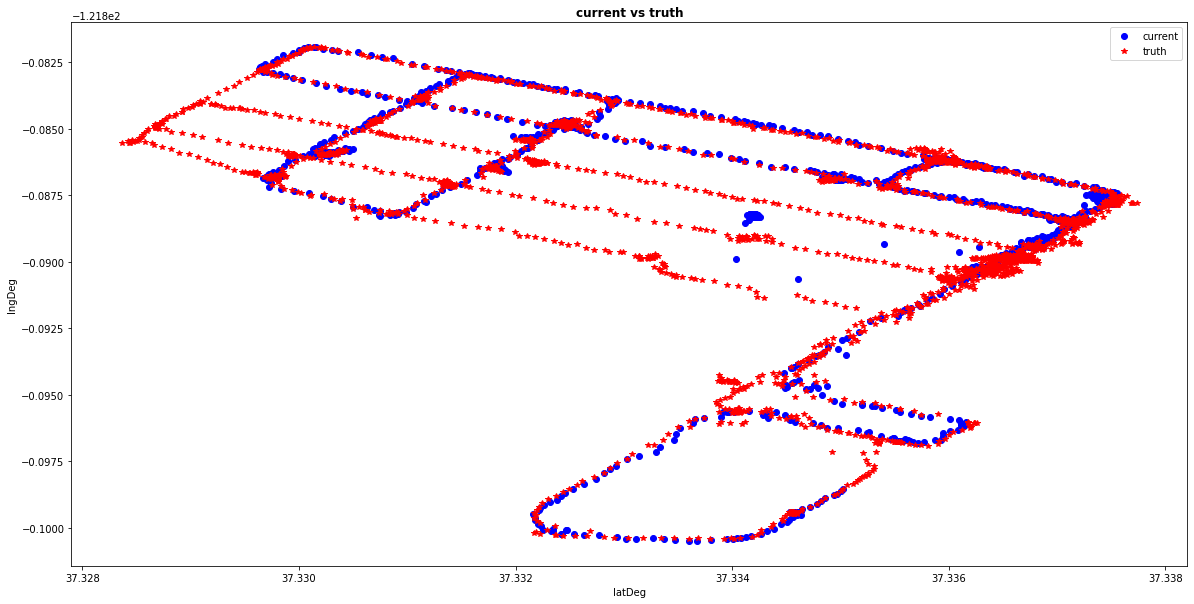

In [ ]:
plt.figure(figsize=[20,10])
plt.plot(imu_predictions[imu_predictions['phone'] == '2021-04-22-US-SJC-2_SamsungS20Ultra'].copy().reset_index(drop = True)["latDeg"][:],
         imu_predictions[imu_predictions['phone'] == '2021-04-22-US-SJC-2_SamsungS20Ultra'].copy().reset_index(drop = True)["lngDeg"][:],"bo",label="current")
plt.plot(BASELINE_TEST[BASELINE_TEST['phone'] == '2021-04-22-US-SJC-2_SamsungS20Ultra'].copy().reset_index(drop = True)["latDeg"][:],
         BASELINE_TEST[BASELINE_TEST['phone'] == '2021-04-22-US-SJC-2_SamsungS20Ultra'].copy().reset_index(drop = True)["lngDeg"][:],"r*",label="truth")
plt.title("current vs truth", fontweight="bold")
plt.xlabel("latDeg")
plt.ylabel("lngDeg")
plt.legend()